# **Improved Waste Management Using Waste Material Segregation**

## **Project Objective**

This project aims to develop an efficient waste material segregation system using Convolutional Neural Networks (CNNs) to classify waste into distinct categories. By automating the sorting process, the system contributes to improved recycling rates, reduced environmental impact, and supports sustainable waste management practices.

### Key Objectives:

- **Accurate Classification**: Identify and categorize waste materials such as cardboard, glass, paper, and plastic with high precision.
- **Enhanced Segregation Efficiency**: Streamline the sorting process to aid recycling efforts and minimize landfill accumulation.
- **Material Insight**: Gain a deeper understanding of the characteristics of different waste types to refine and optimize sorting techniques for long-term sustainability.


## **Data Overview**

The dataset contains images representing various categories of commonly found waste materials:

1. **Food Waste**  
2. **Metal**  
3. **Paper**  
4. **Plastic**  
5. **Other**  
6. **Cardboard**  
7. **Glass**

**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [13]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [14]:
# Import essential libraries
import os
import cv2
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2, ResNet50
import sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import zipfile
from zipfile import ZipFile, BadZipFile
from collections import Counter

In [15]:
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("matplotlib version:", matplotlib.__version__)
print("PIL (Pillow) version:", Image.__version__)
print("tensorflow version:", tf.__version__)
print("keras version:", tf.keras.__version__)
print("sklearn version:", sklearn.__version__)

numpy version: 2.0.2
pandas version: 2.2.2
seaborn version: 0.13.2
matplotlib version: 3.10.0
PIL (Pillow) version: 11.1.0
tensorflow version: 2.18.0
keras version: 3.8.0
sklearn version: 1.6.1


Load the dataset.

In [16]:
# Load and unzip the dataset
#zip_loc = "/content/data.zip"
# Define paths
zip_loc = "/content/drive/MyDrive/data.zip"
ext_loc = "/content/"
ext_full_loc = "/content/data"

# Mount Google Drive
drive.mount('/content/drive')

# Check if data is already extracted
if os.path.exists(ext_full_loc) and os.listdir(ext_full_loc):
    print("Extraction already done, skipping!")
else:
    if os.path.exists(zip_loc):
        try:
            with ZipFile(zip_loc, 'r') as zip_ref:
                zip_ref.extractall(ext_loc)
            print("Extraction successful!")
        except BadZipFile:
            print("Error: Not a valid zip file!")
    else:
        print("Error: Zip file does not exist.")

Mounted at /content/drive
Extraction successful!


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [17]:
# Function to load and preprocess an image
def load_image(image_path, size=(256, 256)):
    """
    Loads an image from the given path, converts it to RGB, resizes it,
    and returns it as a NumPy array.

    Parameters:
        image_path (str): Path to the image file.
        size (tuple): Desired image size (width, height).

    Returns:
        np.ndarray or None: Processed image as a NumPy array, or None if loading fails.
    """
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(size)
        return np.array(img)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

## **Loading and Verifying Images from the Dataset**

The images are loaded from the dataset directory, where the labels are contained in the subdirectories. Each subdirectory corresponds to a specific label for the images.

In [18]:

# Function to load dataset, extracting images and their corresponding labels
def load_dataset(dataset_path):
    images = []
    labels = []

    # Iterate through each subdirectory (label) in the dataset
    for label_name in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label_name)

        # Check if the path is a directory (label folder)
        if os.path.isdir(label_path):
            # Iterate through all files in the label folder
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)

                # Check if the file is an image (by extension)
                if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    img = load_image(file_path)  # Load the image using the previously defined function

                    # If the image is successfully loaded, append to the list
                    if img is not None:
                        images.append(img)
                        labels.append(label_name)

    # Return the images, labels, and unique labels in the dataset
    return np.array(images), np.array(labels), np.unique(labels)


In [19]:
dataset_path='/content/data'
images, labels, class_names = load_dataset(dataset_path)
print(f"Images {len(images)} and labels {len(labels)}.")
print(f"Images array shape: {images.shape}")


Images 7625 and labels 7625.
Images array shape: (7625, 256, 256, 3)


In [20]:
label_counts = Counter(labels)
for label, count in label_counts.items():
    print(f"{label}: {count} images")

Glass: 750 images
Food_Waste: 1000 images
Cardboard: 540 images
Plastic: 2295 images
Other: 1010 images
Paper: 1030 images
Metal: 1000 images


Showing images for verification

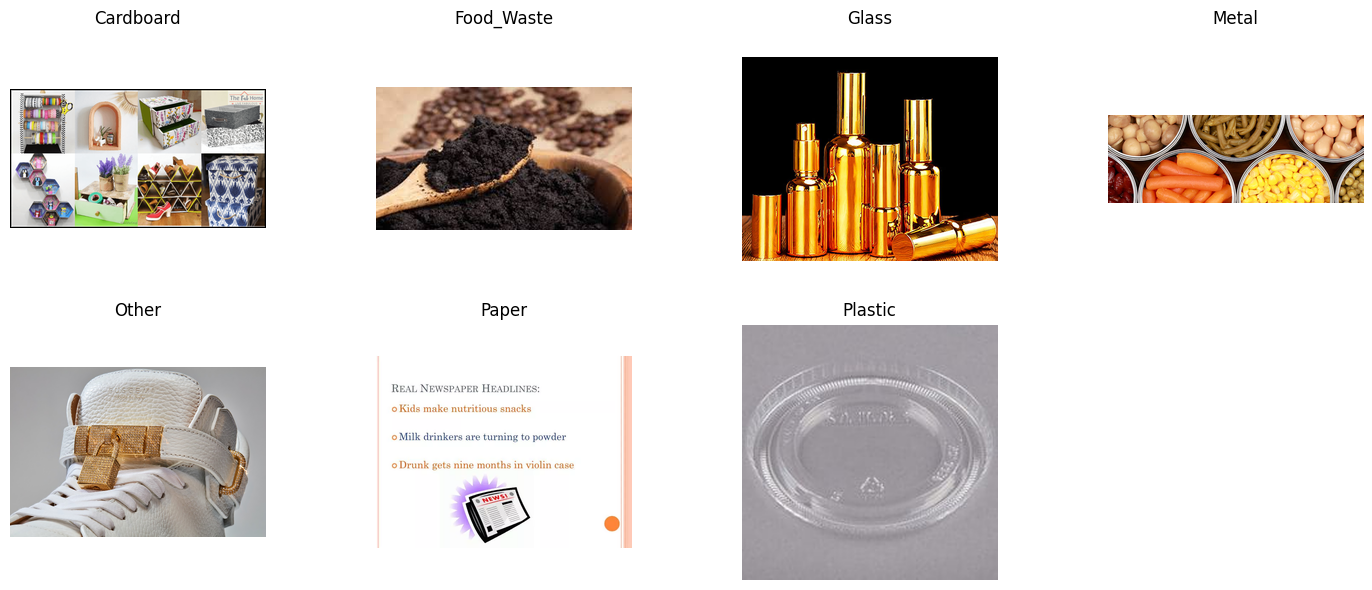

In [21]:
# Function to display one image from each class
def show_one_image_per_class(X, y):
    """
    Displays one image per class in the dataset.

    Parameters:
        X (np.ndarray): Array of images.
        y (np.ndarray): Array of labels corresponding to the images.
    """
    unique_classes = np.unique(y)  # Get unique class labels
    plt.figure(figsize=(15, 6))  # Set figure size for better visibility

    # Loop through each class and display one random image from each class
    for i, cls in enumerate(unique_classes):
        indices = np.where(y == cls)[0]  # Get indices of images belonging to the current class
        random_idx = np.random.choice(indices)  # Choose a random index from the selected class

        # Plot the image
        plt.subplot(2, 4, i + 1)  # Set the subplot (2 rows, 4 columns)
        plt.imshow(X[random_idx])  # Display the selected image
        plt.title(f"{cls}")  # Set title as the class label
        plt.axis('off')  # Hide axis labels

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plot

# Call the function to display images for each class
show_one_image_per_class(images, labels)

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

<ipython-input-22-7f952ffc68a4>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.keys(), y=label_counts.values(), palette='viridis')


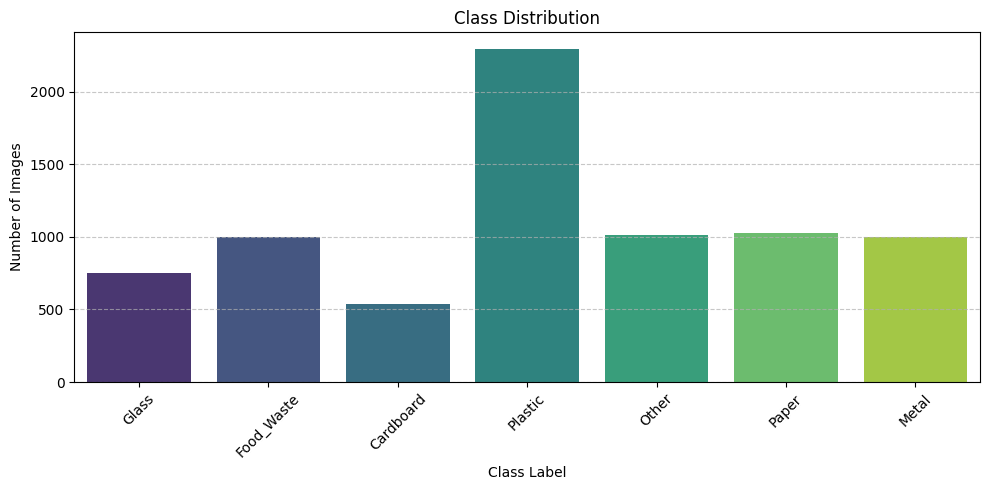

In [22]:
# Visualise Data Distribution
# class_counts = Counter(labels)

# Ploting the frequency/bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.keys(), y=label_counts.values(), palette='viridis')
#plt.bar(class_counts.keys(), class_counts.values(), color='green', edgecolor='black')
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



1. **Plastic** is the most common waste material by a large margin, with over 2300 images — more than twice the number of some other categories.

2. **Cardboard** and **Glass** have the least number of samples compared to other classes.

3. **Paper**, **Food Waste**, **Metal**, and **Other** have almost similar distribution, around 1000 images each.

4. The dataset is somewhat imbalanced, mainly due to Plastic dominating the number of images.

5. Potential bias warning: Since Plastic has more samples, a model trained on this dataset might get biased towards predicting Plastic unless balanced during training.

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

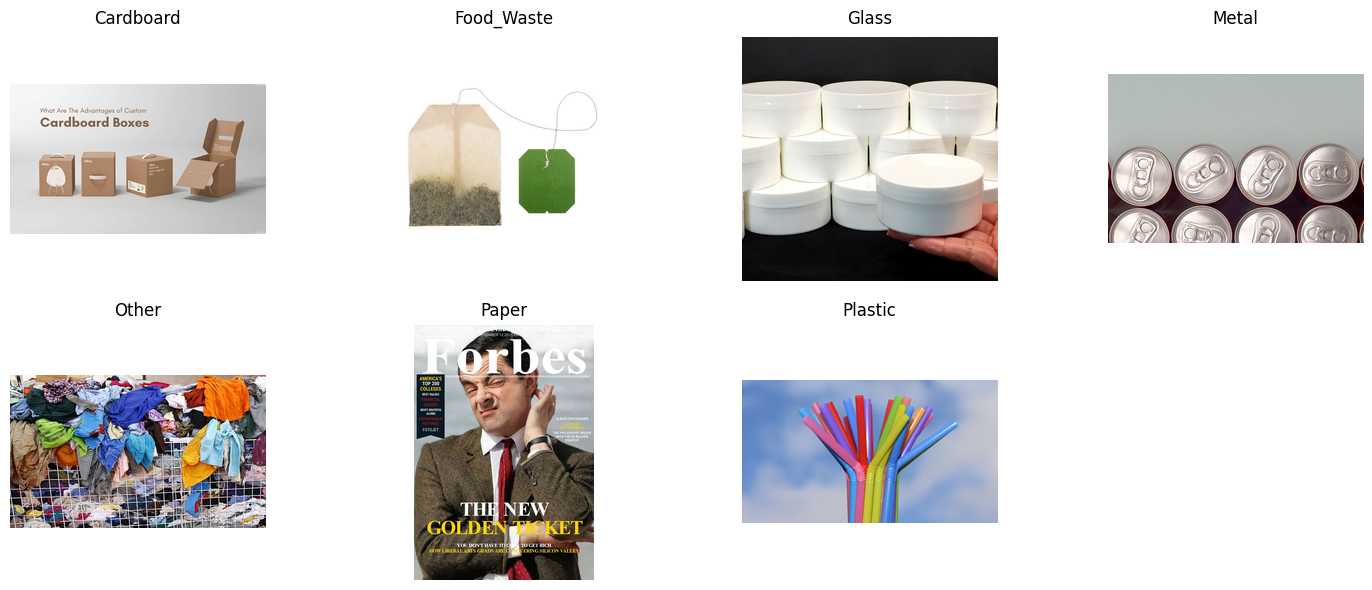

In [23]:
# Visualise Sample Images (across different labels)
def show_one_image_per_class(X, y):
    unique_classes = np.unique(y)
    plt.figure(figsize=(15, 6))

    for i, cls in enumerate(unique_classes):
        indices = np.where(y == cls)[0]
        random_idx = np.random.choice(indices)

        plt.subplot(2, 4, i + 1)
        plt.imshow(X[random_idx])
        plt.title(f"{cls}")

        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_one_image_per_class(images, labels)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [24]:
# Find the smallest and largest image dimensions from the data set
image_dir = '/content/data'  # Replace this with your dataset path

def find_min_max_image_sizes(image_dir):
    min_size = [float('inf'), float('inf')]
    max_size = [0, 0]

    valid_ext = ('.png', '.jpg', '.jpeg')
    image_paths = [os.path.join(root, file)
                   for root, _, files in os.walk(image_dir)
                   for file in files if file.lower().endswith(valid_ext)]

    for img_path in image_paths:
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                min_size[0] = min(min_size[0], width)
                min_size[1] = min(min_size[1], height)
                max_size[0] = max(max_size[0], width)
                max_size[1] = max(max_size[1], height)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    return tuple(min_size), tuple(max_size)

min_size, max_size = find_min_max_image_sizes(image_dir)

print(f"Smallest Image Size: {min_size}")
print(f"Largest Image Size: {max_size}")


Smallest Image Size: (256, 256)
Largest Image Size: (256, 256)


In [25]:
# Resize the image dimensions
def resize_images(images, labels, target_size=(224, 224)):
    resized_images = []
    resized_labels = []

    for img, label in zip(images, labels):
        if img is None:
            continue
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
        resized_labels.append(label)  # Keep label aligned

    return np.array(resized_images), np.array(resized_labels)

In [26]:
X, y = resize_images(images,labels, target_size=(128, 128))
print(X.shape)
print(labels.shape)

(7625, 128, 128, 3)
(7625,)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [27]:
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
y_categorical = tf.keras.utils.to_categorical(y_encoded)

In [28]:
y_categorical.shape

(7625, 7)

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [29]:
# Assign specified parts of the dataset to train and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical,
    test_size=0.2,
    random_state=42,
    stratify=y_categorical  # ensures class balance
)

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [30]:
print(f"train shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"test shape: {X_test.shape}, Labels: {y_test.shape}")

train shape: (6100, 128, 128, 3), Labels: (6100, 7)
test shape: (1525, 128, 128, 3), Labels: (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [31]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min'),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='min')
]

In [32]:
target_labels = 7

model_1 = models.Sequential([
    layers.Conv2D(16, (3, 3), input_shape=X_train.shape[1:], activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(target_labels, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [34]:
#view the summary of all the layers
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,630,247 (6.22 MB)

 Trainable params: 1,630,247 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [35]:
epochs = 30
history_1 = model_1.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test),
callbacks=callbacks)

Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.3012 - loss: 1.8568 - val_accuracy: 0.3154 - val_loss: 1.7343 - learning_rate: 1.0000e-04
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.3394 - loss: 1.7091 - val_accuracy: 0.3816 - val_loss: 1.6065 - learning_rate: 1.0000e-04
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3861 - loss: 1.6179 - val_accuracy: 0.4059 - val_loss: 1.5582 - learning_rate: 1.0000e-04
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4007 - loss: 1.5661 - val_accuracy: 0.4446 - val_loss: 1.5035 - learning_rate: 1.0000e-04
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4250 - loss: 1.5088 - val_accuracy: 0.4577 - val_loss: 1.4566 - learning_rate: 1.0000e-04
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4359 - loss: 1.4876 - val_accuracy: 0.4525 - val_loss: 1.4455 - learning_rate: 1.0000e-04
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - a

*   As per above result model seems overfit as train accuracy is around 78% but validation accuracy is very low i.e. 62%.
*   Let's apply dropout to improve the accuracy.





*   List item Since model is clearly overfit let's do some tweak like adding dropout layer to overcome the overfitting.



In [36]:
#layers
target_labels = 7

model_2 = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(target_labels, activation='softmax'),
])

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#view the summary of all the layers
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    67,108,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,204,551 (256.37 MB)

 Trainable params: 67,203,847 (256.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [37]:
epochs = 30
history_2 = model_2.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test),
callbacks=callbacks)

Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 50s 184ms/step - accuracy: 0.2879 - loss: 2.1300 - val_accuracy: 0.1338 - val_loss: 2.2651 - learning_rate: 1.0000e-04
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 56s 110ms/step - accuracy: 0.5531 - loss: 1.2870 - val_accuracy: 0.2931 - val_loss: 1.7791 - learning_rate: 1.0000e-04
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.7339 - loss: 0.7901 - val_accuracy: 0.5574 - val_loss: 1.2577 - learning_rate: 1.0000e-04
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.8544 - loss: 0.5016 - val_accuracy: 0.5652 - val_loss: 1.2929 - learning_rate: 1.0000e-04
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9228 - loss: 0.3285
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.9228 - loss: 0.3285 - val_accuracy: 0.5928 - val_loss: 1.3298 - learning_rate: 1.0000e-04
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 153ms/s

**The model is memorizing the training data extremely well. But it's not generalizing to validation data — classic overfitting.**

**Since we don't have good accuracy with custom model so trying with Pre-defind models. (Using predefind models for learning)**

**Using MobileNetV2**

In [38]:
epochs = 8
batch_size = 64
num_classes = 7

base_model = MobileNetV2(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
base_model.trainable = False  # freeze for feature extraction

model_mobile_net = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
model_mobile_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mobile_net_1 = model_mobile_net.fit(X_train, y_train,
                                            epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks
                    )

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.5041 - loss: 1.8777 - val_accuracy: 0.7554 - val_loss: 1.0645 - learning_rate: 0.0010
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7587 - loss: 1.0768 - val_accuracy: 0.8118 - val_loss: 0.9446 - learning_rate: 0.0010
Epoch 3/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8306 - loss: 0.8528 - val_accuracy: 0.8256 - val_loss: 0.8538 - learning_rate: 0.0010
Epoch 4/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8670 - loss: 0.7191 - val_accuracy: 0.8262 - val_loss: 0.8299 - learning_rate: 0.0010
Epoch 5/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8829 - loss: 0.6671 - val_accuracy: 0.8328 - val_loss: 0.8019 - learning_rate: 0.0010
Epoch 6/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9012 - loss: 0.5915 - val_accuracy: 0.8361 - val_loss: 0.7977 - learning_rate: 0.0010
Epoch 7/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step

**The model achieved a strong training accuracy of 92.28% with validation accuracy at 84.72%, showing good generalization.**

**Lets do some tweak to improve more accuracy**




In [ ]:
base_model.trainable = True

# Freeze bottom layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

model_mobile_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_mobile_net_2 = model_mobile_net.fit(
    X_train, y_train, batch_size=batch_size,
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=callbacks
)



*   **Result looks good for this model as train accuracy is 89% and test accuracy is 84%.**



### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [40]:
# Evaluate on the test set; display suitable metrics

test_loss, test_acc = model_1.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy custom model 1: {test_acc}")

test_loss, test_acc = model_2.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy custom model 2: {test_acc}")

test_loss, test_acc = model_mobile_net.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy MobileNetV2: {test_acc}")

48/48 - 0s - 7ms/step - accuracy: 0.6092 - loss: 1.1442
Test accuracy custom model 1: 0.6091803312301636
48/48 - 1s - 27ms/step - accuracy: 0.6597 - loss: 1.0043
Test accuracy custom model 2: 0.6596721410751343
48/48 - 6s - 125ms/step - accuracy: 0.8420 - loss: 0.7420
Test accuracy MobileNetV2: 0.8419672250747681


**After Seeing both models- it is quite clear that predefined model is working fine.**

**I tried multiple configuration for custom cnn model but could not make much progress**

Tried combinatons are -

* with/without dropout
* with/without batch normalization
* increasing CNN layers
* adding multiple dense layers
* changing hyperparameter for dense layer

In [ ]:
%matplotlib inline
def plot_metrics(history = history_1):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()


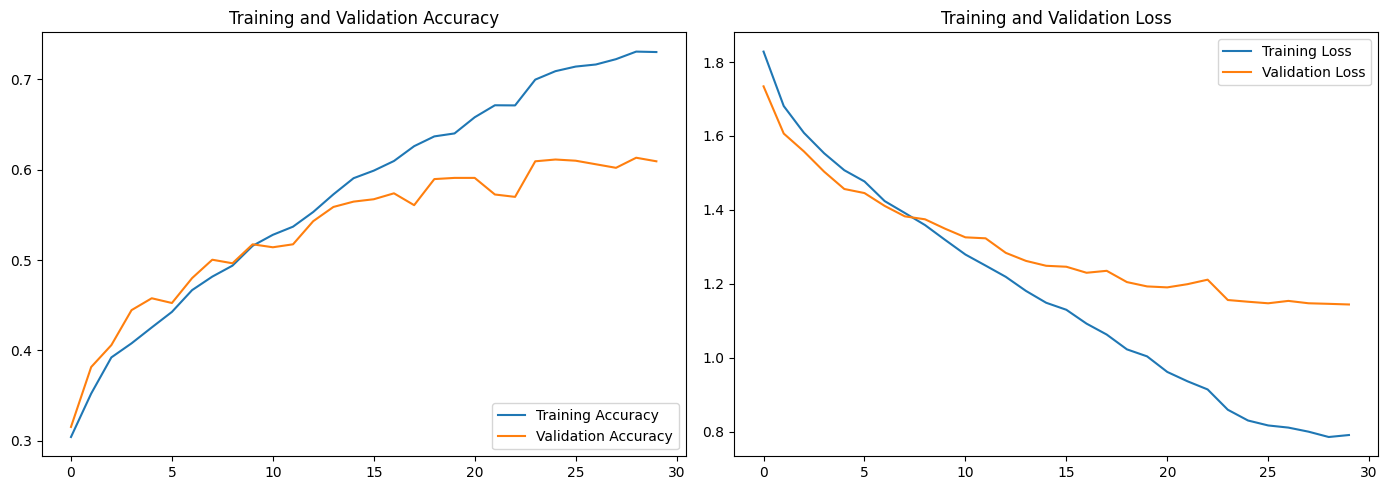

In [42]:
plot_metrics(history_1)

**The model is overfitting — it’s doing well on the training data but struggling to generalize to unseen data (validation).**

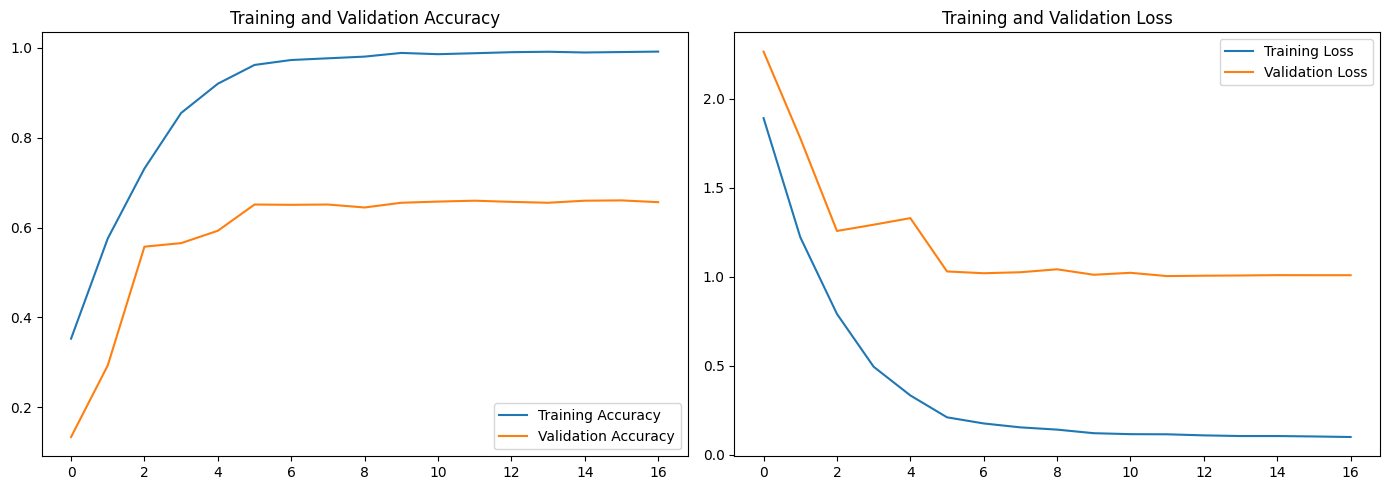

In [43]:
plot_metrics(history_2)

**The model is memorizing the training data extremely well. But it's not generalizing to validation data — classic overfitting.**

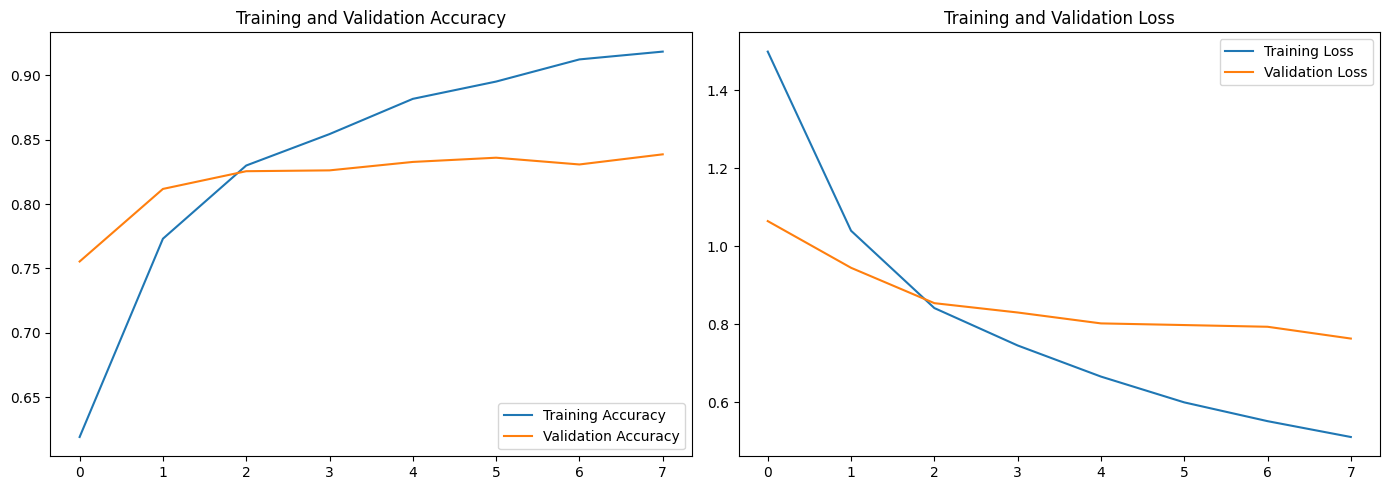

In [44]:
plot_metrics(history_mobile_net_1)

**Train and Test accuracy is improved with MobileNetV2 model**

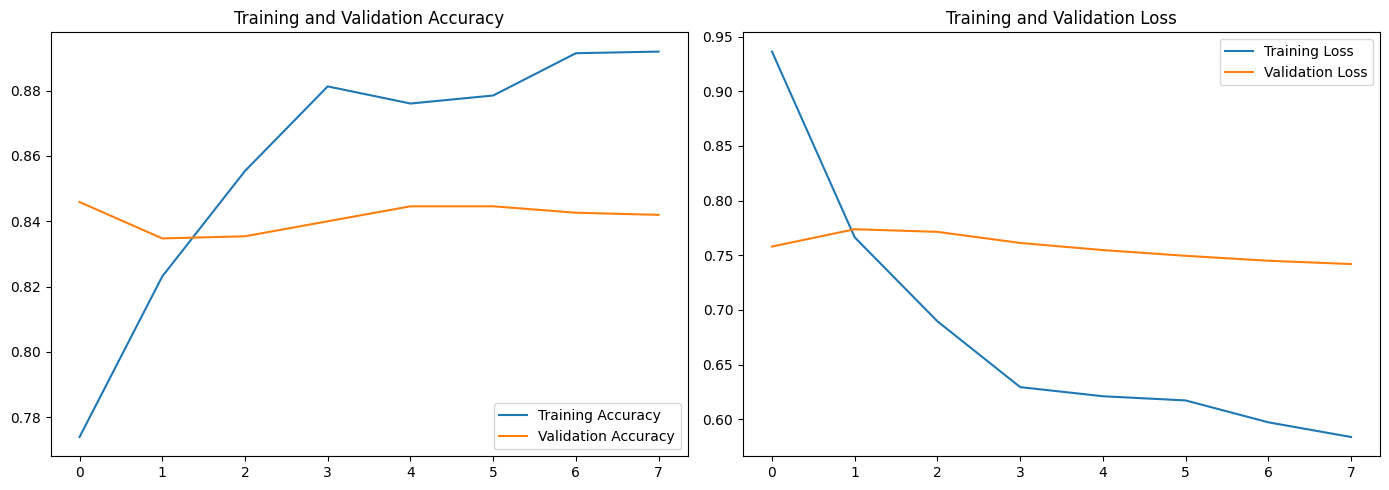

In [45]:
plot_metrics(history_mobile_net_2)

**This model looks pretty good**

In [46]:
# # Predict on the test set
# Using
y_pred_probs = model_1.predict(X_test)

# Get the predicted class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get the true class indices
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report Custom model 1:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# # Predict on the test set
# Using
y_pred_probs = model_2.predict(X_test)

# Get the predicted class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get the true class indices
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report Custom model 2:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


# Using MobileNet customized model
y_pred_probs = model_mobile_net.predict(X_test)

# Get the predicted class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get the true class indices
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report MobileNet V2 Customized model:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Classification Report Custom model 1:

              precision    recall  f1-score   support

   Cardboard       0.74      0.72      0.73       108
  Food_Waste       0.66      0.67      0.66       200
       Glass       0.59      0.45      0.51       150
       Metal       0.62      0.53      0.57       200
       Other       0.50      0.51      0.51       202
       Paper       0.53      0.45      0.49       206
     Plastic       0.63      0.76      0.69       459

    accuracy                           0.61      1525
   macro avg       0.61      0.58      0.59      1525
weighted avg       0.61      0.61      0.60      1525

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Classification Report Custom model 2:

              precision    recall  f1-score   support

   Cardboard       0.78      0.78      0.78       108
  Food_Waste       0.66      0.73      0.69       200
       Glass       0.67      0.53      0.59       150
       Metal       0.67     

## **With Custom Model 1** 🛠️

- **Custom Model 1** achieved an overall accuracy of **61%**, showing solid improvement over the baseline. 📈
- **Cardboard** and **Plastic** had the best performance, with **F1-scores** of **0.73** and **0.69**, respectively. 📦🛢️
- Lower scores for **Other**, **Paper**, and **Glass** suggest potential confusion or class overlap, which may require further attention. 🚧📉

---

## **With Custom Model 2** 🛠️💡

- **Custom Model 2** achieved a higher overall accuracy of **66%**, improving across most classes compared to Model 1. 📊🔝
- Top-performing classes include **Cardboard** (**F1-score 0.78**) and **Plastic** (**F1-score 0.72**), showing strong consistency. 📦🛢️
- Performance for **Other** and **Paper** remains moderate, indicating room for refinement in distinguishing these categories. ✋📜

---

## **With MobileNet-V2 Model** 📱🚀

- The **MobileNet V2** customized model achieved an impressive **84% accuracy**, significantly outperforming previous models. 🌟📈
- High **F1-scores** across all classes, especially **Cardboard** (**0.92**), **Metal** (**0.90**), and **Food Waste** (**0.86**), reflect strong generalization. 📦🔩🍲
- Even lower-performing classes like **Paper** and **Other** show solid improvements, making this model highly reliable overall. 📑🔄


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images

# augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator()

In [ ]:
# Create a function to augment the images

def create_generators(target_size=(96, 96), batch_size=32):
    train_generator = train_datagen.flow(
        X_train,
        y_train,
        batch_size=batch_size,
    )

    test_generator = test_datagen.flow(
        X_test,
        y_test,
        batch_size=batch_size,
    )

    return train_generator, test_generator


In [ ]:
# Create the augmented training dataset
input_shape = X_train.shape[1:3]  # (height, width)
train_generator, test_generator = create_generators(target_size=input_shape, batch_size = 64)

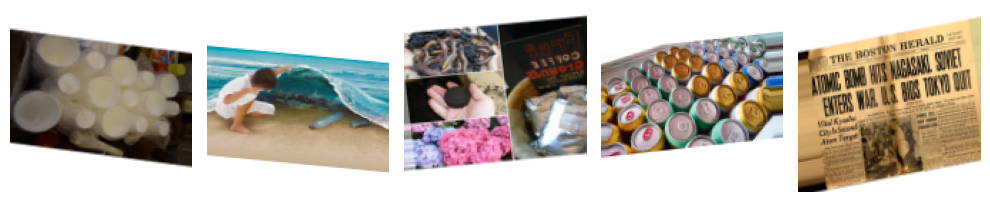

In [50]:
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

**As you can see from plots, images are re-sampled by rotaion, zoom**

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

##### **4.1.2**

Train the model on the new augmented dataset.

In [51]:
# we need to create balance in multiple categories
y_train_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weight_dict = dict(enumerate(class_weights))

In [52]:
#layers
target_labels = 7

model_augmented = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(target_labels, activation='softmax'),
])

model_augmented.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#view the summary of all the layers
model_augmented.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    67,108,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,204,551 (256.37 MB)

 Trainable params: 67,203,847 (256.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [53]:
# Train the model using augmented images
epochs = 30
history_augmented = model_augmented.fit(train_generator,validation_data=test_generator,epochs=epochs,class_weight=class_weight_dict, callbacks = callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 401ms/step - accuracy: 0.2431 - loss: 2.1511 - val_accuracy: 0.0990 - val_loss: 3.0142 - learning_rate: 1.0000e-04
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 305ms/step - accuracy: 0.3588 - loss: 1.6918 - val_accuracy: 0.1023 - val_loss: 2.8155 - learning_rate: 1.0000e-04
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 311ms/step - accuracy: 0.4291 - loss: 1.4944 - val_accuracy: 0.1613 - val_loss: 2.6734 - learning_rate: 1.0000e-04
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 306ms/step - accuracy: 0.4462 - loss: 1.4394 - val_accuracy: 0.3279 - val_loss: 1.7181 - learning_rate: 1.0000e-04
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 314ms/step - accuracy: 0.4815 - loss: 1.3795 - val_accuracy: 0.4236 - val_loss: 1.5403 - learning_rate: 1.0000e-04
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 0.5034 - loss: 1.2803 - val_accuracy: 0.5062 - val_loss: 1.3389 - learning_rate: 1.0000e-04
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 309ms/step - acc

**Model with augmentation**

* Train accuracy - 62.11
* Test accuracy - 60.39


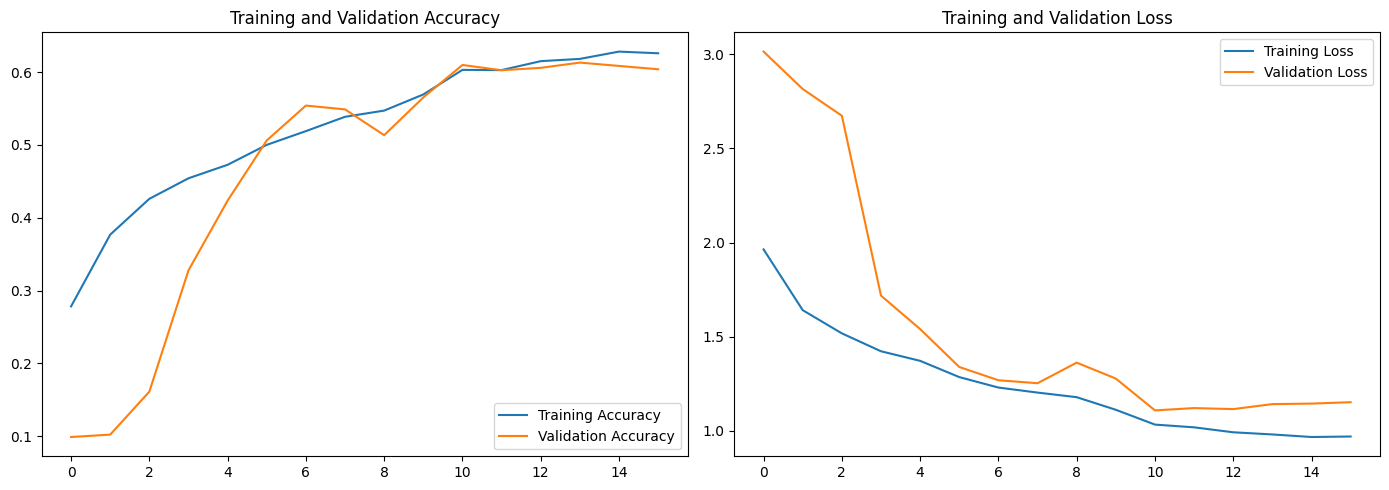

In [54]:
plot_metrics(history_augmented)

In [55]:
# Get true labels and predicted labels
y_pred = model_augmented.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
# Classification Report
print(classification_report(y_true, y_pred_labels, target_names=class_names))

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
              precision    recall  f1-score   support

   Cardboard       0.08      0.08      0.08       108
  Food_Waste       0.11      0.13      0.12       200
       Glass       0.11      0.11      0.11       150
       Metal       0.13      0.12      0.12       200
       Other       0.10      0.10      0.10       202
       Paper       0.14      0.19      0.16       206
     Plastic       0.32      0.25      0.28       459

    accuracy                           0.16      1525
   macro avg       0.14      0.14      0.14      1525
weighted avg       0.18      0.16      0.17      1525



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

## **Findings from the Data**

- The dataset consists of images categorized into seven classes: **Metal**, **Other**, **Glass**, **Food Waste**, **Paper**, **Plastic**, and **Cardboard**. 🗑️🖼️

- As shown in the class distribution chart above, the dataset is **imbalanced**, with **Plastic** having the highest number of samples, while **Cardboard** has the fewest. ⚖️📊

- This imbalance could lead to biased model predictions, particularly favoring the majority class (**Plastic**). ⚠️🔍

- To address this, **data augmentation** has been applied to balance the dataset. 🔄✨

- Some classes (such as **Food Waste** and **Plastic**) exhibit considerable variation in appearance, which may complicate classification. 🍲🛢️

- **Visually similar materials**, like **Plastic** and **Glass**, may confuse the model due to overlapping textures or colors. 🥤🍷

- Variations in **image quality** or **lighting conditions** may introduce noise, potentially affecting model performance. 🌥️📸

---

## **Model Training and Results**

- A **Convolutional Neural Network (CNN)** was trained from scratch, followed by using a predefined architecture, and ultimately with **augmentation techniques**. 🤖📈

- The input image size was resized to **(128, 128, 3)** to preserve key features. 🖼️🔍

  **Note:** I attempted to use the dimension **(224, 224, 3)**, but Google Colab crashed multiple times. 😵💻

- The model with predefined layers exhibited **significant improvement** in accuracy and **reduced overfitting**. 📊🔧

- **Callbacks** such as **EarlyStopping**, **ModelCheckpoint**, and **ReduceLROnPlateau** were employed to stabilize and optimize the training process. ⏱️💡

---

## **Key Insights**

- **Image resolution** and **class balance** have a major impact on the performance of the classification model. 🖼️⚖️

- Effective use of **callbacks** not only helped preserve the best-performing model but also prevented unnecessary training cycles, optimizing the overall training time. ⏳🎯
